In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage
import pickle

# Import Data
and visualize a few examples

In [4]:
!curl -o keren.tar.gz https://storage.googleapis.com/bebi205-spring2023/keren.tar.gz
!tar -xzvf keren.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3238M  100 3238M    0     0  32.5M      0  0:01:40  0:01:37  0:00:03 34.5M:02:05  0:00:19  0:01:46 30.8M      0  0:02:03  0:00:21  0:01:42 30.9M9.7M      0  0:01:48  0:00:40  0:01:08 36.2M   0  0:01:41  0:01:12  0:00:29 39.2M 31.9M      0  0:01:41  0:01:27  0:00:14 33.4M    0  0:01:41  0:01:35  0:00:06 30.5MM      0  0:01:39  0:01:38  0:00:01 43.9M     0  0:01:39  0:01:39 --:--:-- 46.5M
x keren/
x keren/Point01.npz
x keren/Point02.npz
x keren/Point04.npz
x keren/Point05.npz
x keren/Point06.npz
x keren/Point07.npz
x keren/Point08.npz
x keren/Point09.npz
x keren/Point10.npz
x keren/Point11.npz
x keren/Point12.npz
x keren/Point13.npz
x keren/Point14.npz
x keren/Point15.npz
x keren/Point16.npz
x keren/Point17.npz
x keren/Point18.npz
x keren/Point19.npz
x keren/Point20.npz
x keren/Point21.npz
x keren/Point22.npz
x keren/Point23.npz

In [87]:
p1 = np.load('keren/Point39.npz', allow_pickle=True)
X1 = p1['X']
Y1 = p1['y']
C1 = p1['cell_types']
C1 = C1.item()

In [6]:
import matplotlib.pyplot as plt

In [7]:
y0 = Y1[0,:,:,0]
y1 = Y1[0,:,:,1]

Checking out the y mask

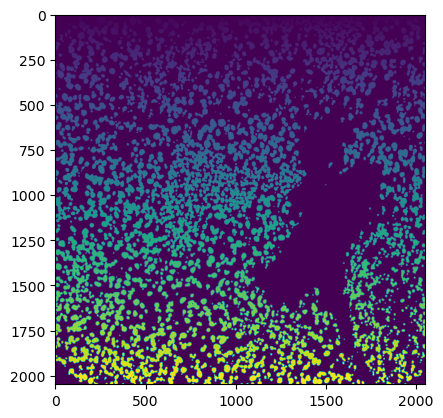

In [8]:
plt.imshow(Y1[0][:,:,1])

Mapping the instance segmentation to semantic segmentation via cell types

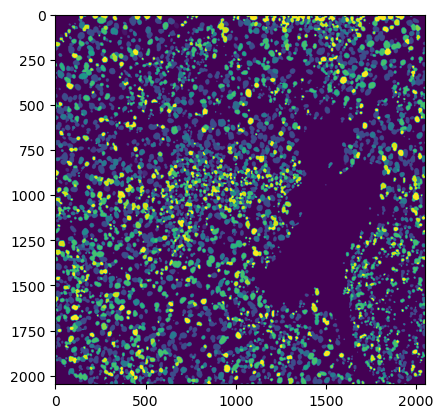

In [9]:
f = lambda x: C1.get(x)
f_vec = np.vectorize(f)
y_ = f_vec(y1)
plt.imshow(y_)

In [10]:
X_n = skimage.exposure.equalize_hist(X1[0])


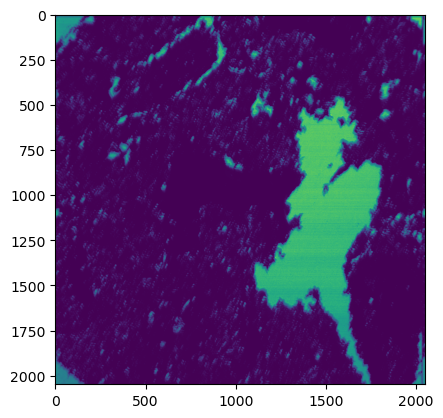

In [11]:
plt.imshow(X1[0,:,:,43])

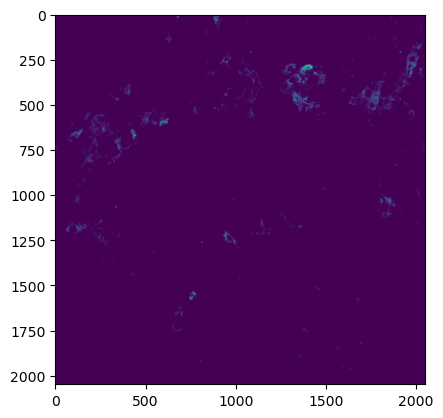

In [12]:
plt.imshow(X_n[:,:,30])

# Making training data




In [166]:
def normalize(X):
  X_n = []
  for c in range(51):
    X_n.append(skimage.exposure.equalize_hist(X[:,:,c]))
  return np.array(X_n)
  
def load_img(file):
  p = np.load(file, allow_pickle=True)
  if(len(p['X'])) > 1:
    print('multiple images in file:',id)
  X = p['X'][0]
  Y = p['y'][0]
  C = p['cell_types']
  C = C.item()

  X_n = normalize(X)
  
  return X,Y,C

def get_cell_box(cell_coord):
  y = cell_coord.transpose()[0]
  x = cell_coord.transpose()[1]

  y_min = np.min(y)
  y_max = np.max(y)

  x_min = np.min(x)
  x_max = np.max(x)

  return y_min,y_max,x_min,x_max

def avg_whole_cell_size(Y_cyto):
  """ chooses 100 random whole cell segmentations, 
      prints std deviation and returns avg dimension"""
  sample = np.random.choice(np.unique(Y_cyto),size = 100)
  x_len = []
  y_len = []
  n = 0
  for cell in sample:
    #if cell == 0:
    #  continue
    cell_coord = np.argwhere(Y_cyto == cell)
    y_min,y_max,x_min,x_max = get_cell_box(cell_coord)
    x_len.append( x_max-x_min)
    y_len.append( y_max-y_min)
    n+=1
  print('. x avg:',np.mean(x_len),'x std:',np.std(x_len))
  print('. y avg:',np.mean(y_len),'y std:',np.std(y_len))
  avg_size = int((np.mean(x_len)+np.mean(y_len))/2)
  print('. Choosing bounding box size =',avg_size)
  return avg_size

def get_coord(Y):
  """ input: Y
      returns: bounding boxes for nuclei as well as average bounding box size
      for whole cells"""
  Y_nuc = Y[:,:,0]
  Y_cyto = Y[:,:,1]

  size = avg_whole_cell_size(Y_cyto)
  
  values = np.unique(Y_nuc)
  coords = {}
  for cell in values:
    #if cell == 0:
    #  continue
    cell_coord = np.argwhere(Y_nuc == cell)
    y_min,y_max,x_min,x_max = get_cell_box(cell_coord)
    coords[cell] = [y_min,y_max,x_min,x_max]

  return coords,size

def crop_cell(X,cell,coords,size = 0):
  """crops cell via bounding box generated by nucleus centroid and size. 
    size argument currently is the average whole cell size"""

  coords_ = coords.copy()
  if size != 0:
    center_y =(coords_[0]+coords_[1])/2
    center_x = (coords_[2]+coords_[3])/2
    
    coords_[0] = max([0,int(center_y-size/2)])
    coords_[1] = min(2048,int(center_y+size/2))
    coords_[2] = max([0,int(center_x-size/2)])
    coords_[3] = min(2048,int(center_x+size/2))

  X_cell = X[coords_[0]:coords_[1],coords_[2]:coords_[3],:]
  return X_cell

def preprocess(X,Y,C,size = 0):
  """ input: full sized image (pre-normalized) 
      output: list of [cropped image of cell,cell type]"""
  coords,size = get_coord(Y)
  print(len(coords))
  cell_images = []
  for cell, box in coords.items():
    cell_images.append([crop_cell(X,cell,box,size = size),C.get(cell)])
  return cell_images

In [14]:
header = [
 'file',
 'cell_type',
 'Au',
 'B7H3',
 'Beta-catenin',
 'C',
 'CD11b',
 'CD11c',
 'CD138',
 'CD16',
 'CD163',
 'CD20',
 'CD209',
 'CD3',
 'CD31',
 'CD4',
 'CD45',
 'CD45RO',
 'CD56',
 'CD63',
 'CD68',
 'CD8',
 'CSF-1R',
 'Ca',
 'EGFR',
 'Fe',
 'FoxP3',
 'H3K27me3',
 'H3K9ac',
 'HLA-DR',
 'HLA-Class-1',
 'IDO',
 'Keratin17',
 'Keratin6',
 'Ki67',
 'Lag3',
 'MPO',
 'Na',
 'OX40',
 'P',
 'PDL1',
 'PD1',
 'PanCK',
 'SMA',
 'Si',
 'Ta',
 'Vimentin',
 'dsDNA',
 'p53',
 'pS6',
 'background',
 'sum of H3K27me3, H3K9ac, and dsDNA',
 'sum_PanCK_CD45',]

In [15]:
cell_dict = {  0: 'Background',
  1: 'Unidentified',
  2: 'Endothelial',
  3: 'Mesenchyme',
  4: 'Tumor',
  5: 'Tregs',
  6: 'CD4T',
  7: 'CD8T',
  8: 'CD3T',
  9: 'Nk',
  10: 'Bcell',
  11: 'Neutrophil',
  12: 'Macrophage',
  13: 'DC',
  14: 'DC_Mono',
  15: 'Mono_Neu',
  16: 'Immune_other',
  17: 'FAILED_HARMONIZATION',}

In [20]:
df = []
cell_images = None
for img_num in range(1,6):#42)
  if img_num == 3:
    continue
  file = str(img_num)
  if img_num < 10:
    file = '0' + str(img_num)
  file = 'keren/Point'+file+'.npz'
  p = np.load(file, allow_pickle=True)
  print("img:",img_num)
  X,Y,C = load_img(file)
  cell_images = preprocess(X,Y,C)
  i = 0
  for cell in cell_images:
    
    row = [img_num,cell_dict.get(cell[1])]
    for c in range(51):
      c_mean = np.mean(cell[0][:,:,c])
      row.append(c_mean)
    df.append(row)


img: 1
. x avg: 18.36 x std: 6.713449188010586
. y avg: 19.79 y std: 7.134837068917552
. size = 19
img: 2
. x avg: 22.17 x std: 9.620867944213764
. y avg: 23.6 y std: 10.019980039900279
. size = 22
img: 4
. x avg: 20.25 x std: 7.236539228111736
. y avg: 21.61 y std: 7.940900452719452
. size = 20
img: 5
. x avg: 21.23 x std: 7.882708925236297
. y avg: 22.14 y std: 8.198804790943617
. size = 21


In [26]:
df = pd.DataFrame(df,columns = header)
df.to_csv('preprocessed_data.csv',index = False)
df

,file,cell_type,Au,B7H3,Beta-catenin,C,CD11b,CD11c,CD138,CD16,...,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,background,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
0,1,FAILED_HARMONIZATION,0.614035,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.377193,0.052632,0.000000,1.600877,0.0,0.197368,0.083333,3.304135,0.223684
1,1,FAILED_HARMONIZATION,3.635965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.394737,2.618421,0.000000,0.464912,0.0,0.052632,0.061404,1.003383,0.596491
2,1,FAILED_HARMONIZATION,0.866667,0.0,0.000000,0.0,0.0,0.0,0.017544,0.000000,...,0.000000,0.389474,0.063158,0.080702,5.670175,0.0,0.273684,0.094737,15.537744,0.203509
3,1,FAILED_HARMONIZATION,0.894737,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.385965,0.049123,0.000000,13.000000,0.0,0.866667,0.147368,39.654737,0.347368
4,1,FAILED_HARMONIZATION,4.814035,0.0,0.000000,0.0,0.0,0.0,0.084211,0.000000,...,0.000000,0.543860,1.842105,0.000000,7.877193,0.0,0.287719,0.084211,17.511278,0.498246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20902,5,FAILED_HARMONIZATION,0.962585,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,1.952381,0.469388,0.176871,3.530612,6.255102,0.0,0.639456,0.088435,14.815223,0.387755
20903,5,FAILED_HARMONIZATION,0.826531,0.0,0.139456,0.0,0.0,0.0,0.000000,0.000000,...,3.479592,0.275510,0.095238,4.238095,2.772109,0.0,0.139456,0.078231,7.190775,0.948980
20904,5,FAILED_HARMONIZATION,0.619048,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020833,...,0.000000,0.416667,0.068452,3.633929,3.258929,0.0,0.136905,0.068452,7.691844,0.529762
20905,5,FAILED_HARMONIZATION,0.720635,0.0,0.641270,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.507937,0.041270,0.000000,0.320635,0.0,1.079365,0.063492,2.051158,0.298413


# Make Correlation Heatmap

In [184]:
df = pd.read_csv('preprocessed_data.csv')
df = pd.read_csv('full_data.csv')

In [185]:
means = df.groupby(['cell_type']).mean()
columns_to_drop = ['file','Au','C','P','Fe','Ca','background']
means = means.drop(labels = columns_to_drop,axis=1)
means

,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,CD3,...,PanCK,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
cell_type,,,,,,,,,,,,,,,,,,,,,
Bcell,0.000000,0.059825,0.024058,0.036579,0.023127,0.019948,0.000142,2.228015,0.001121,0.059112,...,0.038155,0.214118,0.545820,0.648484,1.404800,9.194177,0.013301,0.979696,33.070658,1.355332
CD3T,0.000000,0.072972,0.001797,0.013785,0.036346,0.023100,0.000207,0.065754,0.002997,0.225845,...,0.038293,0.209132,0.839348,1.365622,2.374683,9.291521,0.005810,0.737250,32.250094,1.105028
CD4T,0.000000,0.100371,0.019932,0.111022,0.027134,0.097341,0.000049,0.394887,0.012738,0.533489,...,0.041831,0.204944,1.181665,1.847431,2.808831,8.209502,0.014704,0.793495,28.155578,2.466021
CD8T,0.000003,0.139792,0.010148,0.058863,0.018692,0.081713,0.000157,0.098008,0.012436,0.426207,...,0.073027,0.233166,1.245203,1.906496,2.853585,9.114539,0.025233,0.798115,29.650286,1.963873
DC,0.000000,0.058174,0.021709,0.075310,0.017827,0.132431,0.000826,0.060063,0.607188,0.451646,...,0.010583,0.182359,1.230153,2.255168,2.433682,7.869681,0.008450,0.776167,24.661360,2.031408
DC_Mono,0.000000,0.104337,0.048651,0.239902,0.034537,0.072216,0.000282,0.072829,0.004002,0.099252,...,0.031918,0.168086,0.956444,1.498803,3.123392,7.829651,0.010529,0.756449,26.051174,1.134864
Endothelial,0.000000,0.267199,0.001814,0.006564,0.039355,0.020753,0.000000,0.015270,0.003724,0.014281,...,0.000326,0.566913,1.253819,4.299174,5.693729,7.494520,0.000086,0.529117,25.276445,0.171482
FAILED_HARMONIZATION,0.000037,0.262219,0.009134,0.036503,0.124313,0.109984,0.000072,0.051580,0.004509,0.047210,...,0.201936,0.163419,3.899904,9.317437,1.309881,5.275707,0.073065,0.375285,14.177224,0.603989
Immune_other,0.000038,0.019876,0.001379,0.008495,0.058202,0.019924,0.000092,0.024040,0.001555,0.024450,...,0.007554,0.134198,1.164675,2.004888,1.557307,8.366068,0.001810,0.782488,29.760949,0.500651


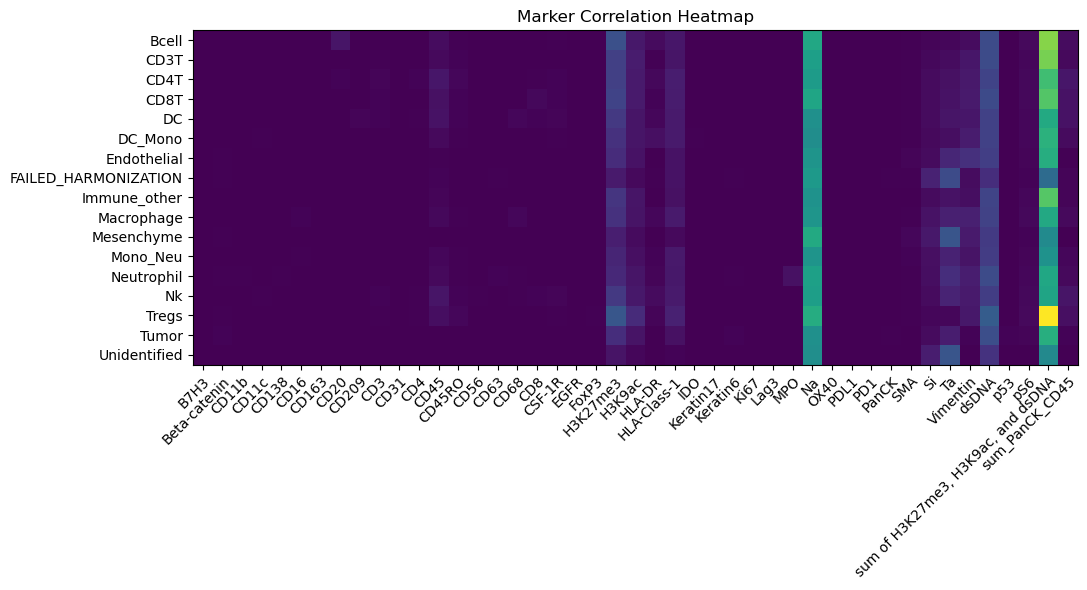

In [186]:
cell_types = means.index.values
markers = means.columns.values



fig, ax = plt.subplots(figsize = (20,6))
im = ax.imshow(means.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(markers)), labels=markers, fontsize = 10)
ax.set_yticks(np.arange(len(cell_types)), labels=cell_types, fontsize = 10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax.set_title("Marker Correlation Heatmap")
fig.tight_layout()
plt.savefig('marker_heatmap.png')
plt.show()

# Logistic Regression Classifier

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [194]:
training_data = df.copy()
columns_to_drop = ['file','Au','C','P','Fe','Ca','background']
rows_to_drop = ['FAILED_HARMONIZATION','Unidentified']
training_data = training_data.drop(labels = columns_to_drop,axis=1)
training_data = training_data[training_data.cell_type.apply(lambda x: x not in rows_to_drop)]
training_data = training_data.dropna() #not sure how a NaN row got added
training_data

,cell_type,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,...,PanCK,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
71,Bcell,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.833333,0.0,...,0.000000,0.0,0.398148,0.200617,0.000000,15.367284,0.000000,1.305556,53.621958,1.000000
72,Macrophage,0.0,0.000000,0.135802,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,37.422840,75.398148,0.000000,5.487654,0.000000,1.012346,14.719841,0.185185
73,Tumor,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.296296,0.0,0.277778,0.530864,0.000000,1.972222,0.000000,0.067901,5.028042,0.296296
75,Tumor,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.487654,0.0,8.117284,10.496914,0.000000,9.645062,0.000000,0.385802,21.708730,0.487654
76,CD8T,0.0,0.000000,0.000000,0.000000,0.055556,0.000000,0.0,0.154321,0.0,...,0.046296,0.0,0.469136,3.268519,0.000000,9.768519,0.000000,0.345679,24.087831,0.913580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99942,Tumor,0.0,0.736842,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.639889,0.074792,0.337950,10.664820,0.609418,0.542936,28.634827,0.096953
99943,Tumor,0.0,0.545706,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.227147,0.0,0.642659,0.058172,0.000000,9.889197,0.293629,0.423823,26.111376,0.310249
99944,Neutrophil,0.0,0.024931,0.000000,0.036011,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.637119,0.063712,0.000000,13.481994,0.000000,0.144044,30.539593,1.002770
99945,Tumor,0.0,0.493075,0.000000,0.000000,0.000000,0.063712,0.0,0.000000,0.0,...,0.000000,0.0,0.639889,0.066482,0.368421,6.249307,0.000000,0.135734,19.033050,0.648199


In [195]:
reverse_map = { 'Background': 0,
  'Unidentified':1,
  'Endothelial':2,
  'Mesenchyme':3,
   'Tumor':4,
   'Tregs':5,
   'CD4T':6,
   'CD8T':7,
   'CD3T':8,
   'Nk':9,
   'Bcell':10,
   'Neutrophil':11,
   'Macrophage':12,
   'DC':13,
   'DC_Mono':14,
   'Mono_Neu':15,
   'Immune_other':16,
   'FAILED_HARMONIZATION':17,}

In [196]:
y = training_data.cell_type.map(reverse_map).values
y.shape

(87790,)

In [197]:
np.unique(y,return_counts= True)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([  804,  2252, 45682,  1218,  5738,  8412,  1986,   324,  2454,
         1420, 10575,   345,  2207,  1714,  2659]))

Interestingly, there is a class imbalance with many Tregs (4) but few DC_mono (40) or Nk (20) cells. However, the confusion matrix shows very poor accuracy on Tregs.

In [198]:
X = (training_data.drop(labels = ['cell_type'],axis = 1)).values
X.shape

(87790, 45)

In [199]:
log = LogisticRegression(C=1,max_iter = 100000,class_weight = 'balanced')
length = len(y)
test_index = int(0.8*length)
log.fit(X[0:test_index], y[0:test_index])   # Fit the ridge regression model to the data

print(log.score(X[test_index:], y[test_index:] ))

y_pred = log.predict(X[test_index:])
cm = confusion_matrix(y[test_index:], y_pred)


0.7920605991570794


# Save and Load Model
- just to make sure it works

In [200]:
import pickle
# save the model to disk
filename = 'model.sav'
pickle.dump(log, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.score(X[test_index:], y[test_index:] )


0.7920605991570794

In [201]:
cm_norm = []
for i in range(len(cm)):
  cm_norm.append(cm[i]/np.sum(cm[i]))
cm_norm = np.array(cm_norm)
cm_norm = np.around(cm_norm, decimals = 2)

In [202]:
cm_labels = [ 'Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T', 'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other']

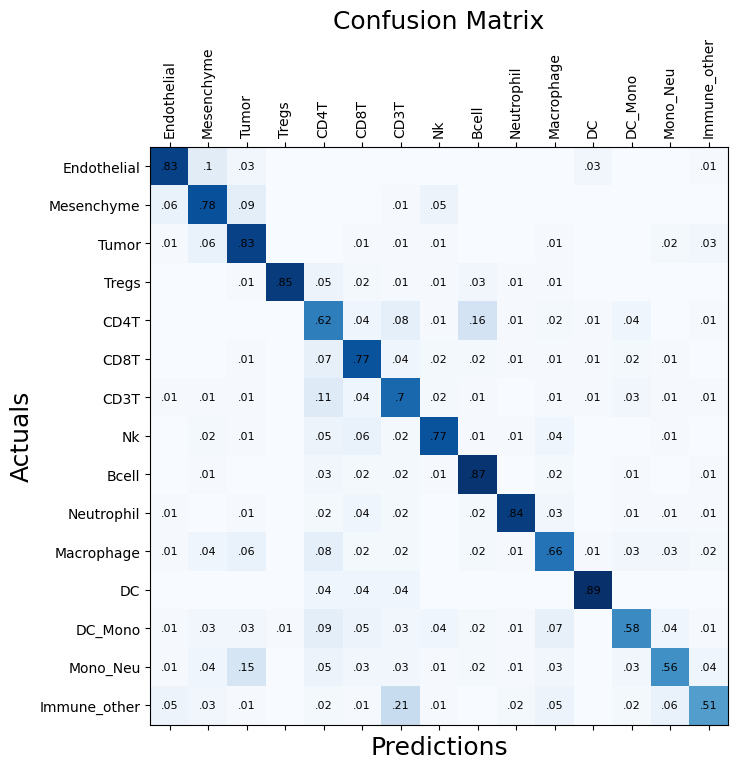

In [215]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm_norm, cmap=plt.cm.Blues,)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        if cm_norm[i, j] != 0:
          s = cm_norm[i, j]
          if s <1: #drop 0 before decimal place
            s=str(cm_norm[i, j])[1:]
          ax.text(x=j, y=i,s=s, va='center', ha='center', fontsize = 8)

ax.set_xticks(np.arange(len(cm_labels)), labels=cm_labels)
ax.set_yticks(np.arange(len(cm_labels)), labels=cm_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation='vertical')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('confusion_matrix.png')
plt.show()

# Wrapper Function for Predicting on a New dataset

In [209]:
def preprocess_and_predict(X,Y,model_file):
    """inputs: X (matrix of shape (1,2048,2048,51) or (2048,2048,51) and 
               Y (matrix of shape (1,2048,2048,2) or (2048,2048,2)
       outputs: y_pred (dictionary of cell_instance:predicted class as a number)"""
    
    if len(X.shape) ==4:
        X = X[0]
        Y = Y[0]
    values = np.unique(Y[:,:,0])
    #make bogus C to avoid changing preprocessing functions just for this
    C  = {}
    for cell_id in values:
        C[cell_id] = cell_id
    #preprocess data
    cell_images = preprocess(X,Y,C)
    df = []
    for cell in cell_images:
        cell_id = cell[1]
        row = [cell_id]
        for c in range(51):
            c_mean = np.mean(cell[0][:,:,c])
            row.append(c_mean)
        df.append(row)
    header = ['cell_id','Au','B7H3','Beta-catenin','C','CD11b','CD11c','CD138','CD16','CD163','CD20','CD209','CD3','CD31','CD4','CD45','CD45RO',
        'CD56','CD63','CD68','CD8','CSF-1R','Ca','EGFR','Fe','FoxP3','H3K27me3','H3K9ac','HLA-DR','HLA-Class-1','IDO','Keratin17','Keratin6','Ki67',
        'Lag3','MPO','Na','OX40','P','PDL1','PD1','PanCK','SMA','Si','Ta','Vimentin','dsDNA','p53','pS6','background','sum of H3K27me3, H3K9ac, and dsDNA',
        'sum_PanCK_CD45']
    df = pd.DataFrame(df,columns = header)
    #make X_test
    y_nums = df['cell_id'].values
    columns_to_drop = ['cell_id','Au','C','P','Fe','Ca','background']
    df = df.drop(labels = columns_to_drop,axis=1)
    X_test = df.values
    
    #load model
    loaded_model = pickle.load(open(model_file, 'rb'))
    
    #predict
    y_pred_ = loaded_model.predict(X_test)
    
    #make dictionary
    y_pred = {}
    for cell_id, pred in zip(y_nums,y_pred_):
        y_pred[cell_id] = pred
    
    return y_pred
    
    

In [217]:
p1 = np.load('keren/Point10.npz', allow_pickle=True)
X1 = p1['X']
Y1 = p1['y']
C1 = p1['cell_types']
C1 = C1.item()

y_pred = preprocess_and_predict(X1,Y1,'model.sav')

. x avg: 19.33 x std: 8.375028358160943
. y avg: 20.71 y std: 9.351251253174626
. Choosing bounding box size = 20
4544


In [218]:
num_right = 0
for i in range(len(y_pred)):
    if y_pred.get(i) == C1.get(i):
        num_right +=1
num_right/len(y_pred)

0.6736355633802817